In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('covid-russia.csv')
df.head(3)

,nday,date,total_cases,new_cases
0,0,2020-03-03,3,1
1,1,2020-03-04,4,1
2,2,2020-03-05,4,0


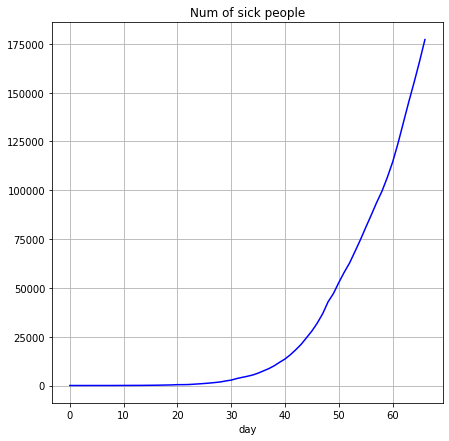

In [3]:
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(df['nday'].values, df['total_cases'].values, color='blue')
ax.set(xlabel='day', title='Num of sick people')
ax.grid()
plt.show()

### Обучим модель с экспоненциальным числом заболевших

$$ y \sim \exp (\alpha \cdot x+\beta) \Leftrightarrow \ln y \sim \alpha \cdot x+\beta$$

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
df['total_cases_log'] = np.log(df['total_cases'])

In [6]:
df['nday'] = df['nday'] + 1

In [7]:
train = df[:50]
test = df[50:]

In [8]:
lr = LinearRegression()
lr.fit(train['nday'].values.reshape(-1, 1), train['total_cases_log'].values)
print("Alpha = %.4f, Beta = %.4f" % (lr.coef_[0], lr.intercept_))

Alpha = 0.2033, Beta = 1.2757


### Воспользуемся Байесовской библиотекой для семплинга Pystan

In [9]:
import pystan

In [19]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;

    int<lower=0> N_new;
    vector[N_new] x_new;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha * x + beta, sigma);
}
generated quantities {
        vector[N_new] y_new;
        y_new = alpha * x_new + beta;      
}
"""

In [22]:
# Put our data in a dictionary
data = {'N': train.shape[0], 
        'x': train['nday'].values, 
        'y': train['total_cases_log'],
        'N_new': df.shape[0],
        'x_new': df['nday'].values, 
       }

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f586f50cb8b28ab7da2214e5800a983b NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/ssfd22r166x8hgqvwvgvf6h40000gn/T/tmpvmkkq0hk/stanfit4anon_model_f586f50cb8b28ab7da2214e5800a983b_6467582782891906997.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [16]:
# для проверки, что цепи сошлись
# import stan_utility
# stan_utility.check_all_diagnostics(fit)

In [23]:
print(fit)

Inference for Stan model: anon_model_f586f50cb8b28ab7da2214e5800a983b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        0.2  1.3e-4 3.9e-3    0.2    0.2    0.2   0.21   0.21    987    1.0
beta        1.28  3.9e-3   0.12   1.05    1.2   1.27   1.35   1.51    903   1.01
sigma       0.38  1.3e-3   0.04   0.31   0.35   0.37    0.4   0.46    942    1.0
y_new[0]    1.48  3.7e-3   0.11   1.26   1.41   1.48   1.55   1.71    905   1.01
y_new[1]    1.68  3.6e-3   0.11   1.47   1.61   1.68   1.75    1.9    907   1.01
y_new[2]    1.89  3.5e-3   0.11   1.68   1.82   1.88   1.96    2.1    910   1.01
y_new[3]    2.09  3.4e-3    0.1   1.89   2.02   2.09   2.16   2.29    913   1.01
y_new[4]    2.29  3.3e-3    0.1    2.1   2.23   2.29   2.36   2.49    917   1.01
y_new[5]     2.5  3.1e-3    0.1   2.31   2.43   2.49   2.56   2.69    922   1.01
y_n

In [29]:
ex = fit.extract(permuted=True) 
ex['y_new'].shape

(2000, 67)

In [94]:
def myplot_sample_lines(df):
    # Посэмплируем и порисуем прямые
    fig, ax = plt.subplots(figsize=(7,7))
    plt.ylim(top=3e5)
    for i in range(0,df.shape[0]):
        ax.plot(df['nday'].values, np.exp(ex['y_new'][i]), 'k-', lw=.1, color = 'gray')
    ax.plot(df['nday'].values, df['total_cases'].values, 'k-', lw=2, color = 'red')
    ax.set(xlabel='day', title='Num of sick people')
    ax.grid()
    plt.show()

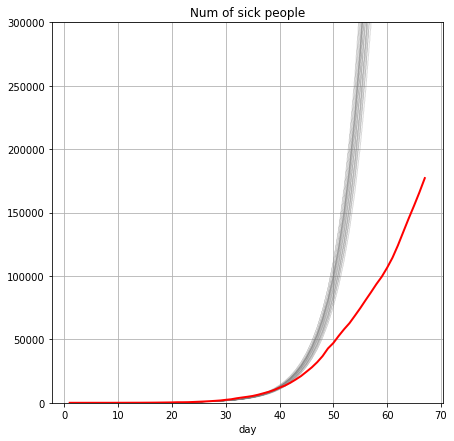

In [95]:
myplot_sample_lines(df)

In [65]:
df[df['nday'].isin([15, 30, 60])][['nday', 'total_cases']]

,nday,total_cases
14,15,93
29,30,2337
59,60,106498


In [60]:
ans = np.exp(np.mean(ex['y_new'], axis=0))[[15, 30, 60]]
print("На 15й день = %.0f, на 30й = %.0f, на 60й = %.0f" % (ans[0], ans[1], ans[2]))

На 15й день = 93, на 30й = 1952, на 60й = 867249


В прошлом ноутбуке получали аналогичные значения

> day = 15, prediction = 70

> day = 30, prediction = 1520

> day = 60, prediction = 846909

#### Воспользовались небольшой магией и получили схожие результаты :)

### Sigmoid approach

Здесь будем рассматривать накопительный эффект, то есть прирост числа заболевших.

Плотность распределения  $\frac{dF(x)}{dx} = \exp (\alpha_1 \cdot x^2 + \alpha_2 \cdot x + \beta)$, отсюда
$$ y \sim \exp (\alpha_1 \cdot x^2 + \alpha_2 \cdot x + \beta) \Leftrightarrow \ln y \sim \alpha_1 \cdot x^2 + \alpha_2 \cdot x + \beta$$

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
df['nday_squared'] = df['nday']**2

In [6]:
df['new_cases_log'] = np.log(df['new_cases'].replace(0, 1))

In [7]:
train = df[:50]
test = df[50:]

In [8]:
lr2 = LinearRegression()
lr2.fit(train[['nday', 'nday_squared']].values, train['new_cases_log'].values)
print("Alpha_1 = %.4f, Alpha_2 = %.4f, Beta = %.4f" % (lr2.coef_[0], lr2.coef_[1], lr2.intercept_))

Alpha_1 = 0.2598, Alpha_2 = -0.0014, Beta = -0.6141


### Воспользуемся Байесовской библиотекой для семплинга Pystan

In [9]:
import pystan

In [15]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] x_sq;
    vector[N] y;

    int<lower=0> N_new;
    vector[N_new] x_new;
    vector[N_new] x_sq_new;
}
parameters {
    real alpha_1;
    real alpha_2;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha_2 * x_sq + alpha_1 * x + beta, sigma);
}
generated quantities {
        vector[N_new] y_new;
        y_new = alpha_2 * x_sq_new + alpha_1 * x_new + beta;      
}
"""

In [16]:
alpha_1, alpha_2 = lr2.coef_[0], lr2.coef_[1]
beta = lr2.intercept_
sigma = 1.0

In [58]:
alpha_1, alpha_2

(0.2598258719977321, -0.0014019694828364504)

In [97]:
# Put our data in a dictionary
data = {'N': train.shape[0], 
        'x': train['nday'].values, 
        'x_sq': train['nday_squared'].values,
        'y': train['new_cases_log'],
        'N_new': df.shape[0],
        'x_new': df['nday'].values, 
        'x_sq_new': df['nday_squared'].values, 
       }

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=4, warmup=1000, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54d9c0bf4223ba1b17a7f74fa0ecc66e NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/ssfd22r166x8hgqvwvgvf6h40000gn/T/tmp0grnsko3/stanfit4anon_model_54d9c0bf4223ba1b17a7f74fa0ecc66e_6760582557125788749.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [98]:
print(fit)

Inference for Stan model: anon_model_54d9c0bf4223ba1b17a7f74fa0ecc66e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_1     0.26  9.5e-4   0.03   0.19   0.24   0.26   0.28   0.33   1207    1.0
alpha_2  -1.4e-3  1.7e-5 6.5e-4-2.7e-3-1.8e-3-1.4e-3-9.7e-4-1.0e-4   1526    nan
beta        -0.6    0.01   0.35  -1.28  -0.84  -0.59  -0.37   0.07   1185    1.0
sigma       0.84  2.3e-3   0.09   0.68   0.78   0.83   0.89   1.02   1417    1.0
y_new[0]    -0.6    0.01   0.35  -1.28  -0.84  -0.59  -0.37   0.07   1185    1.0
y_new[1]   -0.35  9.3e-3   0.32  -0.99  -0.57  -0.34  -0.12   0.28   1210    1.0
y_new[2]   -0.09  8.4e-3    0.3  -0.69  -0.29  -0.08   0.11   0.48   1245    1.0
y_new[3]    0.16  7.6e-3   0.27  -0.39  -0.02   0.17   0.35   0.68   1293    1.0
y_new[4]    0.41  6.8e-3   0.25  -0.09   0.24   0.42   0.58   0.88   1369    1.0
y

In [101]:
ex = fit.extract(permuted=True) 
ex['y_new'].shape

(4000, 67)

In [102]:
def myplot_sample_lines(df):
    # Посэмплируем и порисуем прямые
    fig, ax = plt.subplots(figsize=(7,7))
    plt.ylim(top=2e4)
    for i in range(0,df.shape[0]):
        ax.plot(df['nday'].values, np.exp(ex['y_new'][i]), 'k-', lw=.1, color = 'gray')
    ax.plot(df['nday'].values, df['new_cases'].values, 'k-', lw=2, color = 'red')
    ax.set(xlabel='day', title='Num of sick people (daily)')
    ax.grid()
    plt.show()

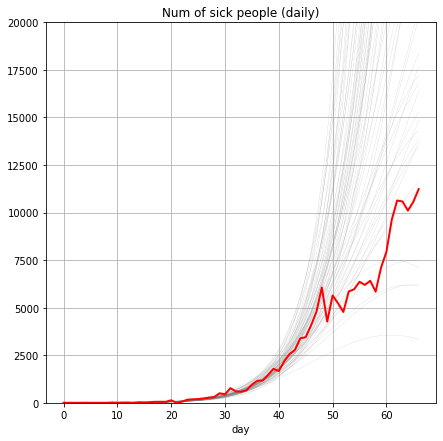

In [103]:
myplot_sample_lines(df)

In [104]:
xs = np.arange(1, 181, 1)
df_new = pd.DataFrame(xs, columns = ['nday'])
df_new['nday_squared'] = df_new['nday']**2

In [106]:
# Put our data in a dictionary
data = {'N': train.shape[0], 
        'x': train['nday'].values, 
        'x_sq': train['nday_squared'].values,
        'y': train['new_cases_log'],
        'N_new': df_new.shape[0],
        'x_new': df_new['nday'].values, 
        'x_sq_new': df_new['nday_squared'].values, 
       }

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=2000, chains=2, warmup=1000, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54d9c0bf4223ba1b17a7f74fa0ecc66e NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2c/ssfd22r166x8hgqvwvgvf6h40000gn/T/tmpmof5zaok/stanfit4anon_model_54d9c0bf4223ba1b17a7f74fa0ecc66e_8329669762557282088.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [107]:
print(fit)

Inference for Stan model: anon_model_54d9c0bf4223ba1b17a7f74fa0ecc66e.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_1      0.26  1.4e-3   0.03    0.2   0.24   0.26   0.28   0.33    544    1.0
alpha_2   -1.4e-3  2.6e-5 6.6e-4-2.7e-3-1.8e-3-1.4e-3-9.6e-4-1.1e-4    630    nan
beta        -0.61    0.02   0.35  -1.28  -0.83  -0.59  -0.38   0.07    532    1.0
sigma        0.84  3.3e-3   0.09   0.68   0.78   0.83    0.9   1.02    719    1.0
y_new[0]    -0.35    0.01   0.32  -0.97  -0.56  -0.34  -0.14   0.27    544    1.0
y_new[1]    -0.09    0.01   0.29  -0.67  -0.29  -0.09    0.1   0.48    594    1.0
y_new[2]     0.16    0.01   0.27  -0.38  -0.02   0.16   0.34   0.68    618    1.0
y_new[3]     0.41  9.8e-3   0.25  -0.09   0.25   0.42   0.57   0.88    652    1.0
y_new[4]     0.65  8.8e-3   0.23   0.19    0.5   0.66   0.81   1.09    69

In [108]:
ex = fit.extract(permuted=True) 
ex['y_new'].shape

(2000, 180)

In [109]:
def myplot_sample_lines(df, df_new):
    # Посэмплируем и порисуем прямые
    fig, ax = plt.subplots(figsize=(7,7))
    plt.ylim(top=2e4)
    for i in range(0,df_new.shape[0]):
        ax.plot(df_new['nday'].values, np.exp(ex['y_new'][i]), 'k-', lw=.1, color = 'gray')
    ax.plot(df['nday'].values, df['new_cases'].values, 'k-', lw=2, color = 'red')
    ax.set(xlabel='day', title='Num of sick people (daily)')
    ax.grid()
    plt.show()

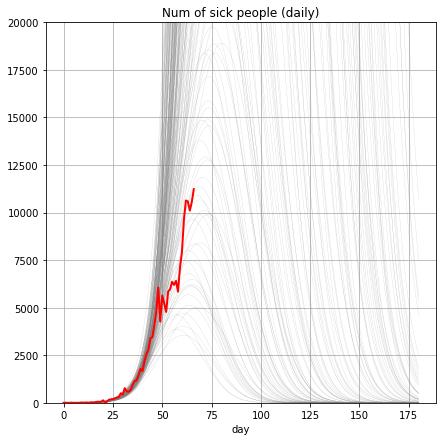

In [110]:
myplot_sample_lines(df, df_new)

In [111]:
def myplot_sample_lines_sigmoid(df, df_new):
    # Посэмплируем и порисуем прямые
    fig, ax = plt.subplots(figsize=(7,7))
    plt.ylim(top=9e6)
    
    out = []
    for i in range(0,df_new.shape[0]):
        n_sick = np.exp(ex['y_new'][i]).cumsum()
        ax.plot(df_new['nday'].values, n_sick, 'k-', lw=.1, color='blue', linestyle='dashed')
        out.append(n_sick[-1])
    ax.plot(df['nday'].values, df['total_cases'].values, 'k-', lw=2, color = 'red')
    ax.set(xlabel='day', title='Num of sick people')
    ax.grid()
    plt.show()
    return out

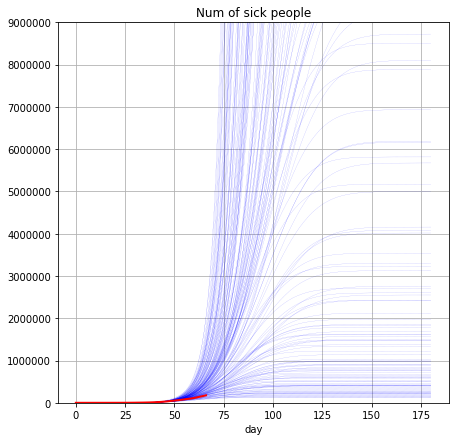

In [112]:
out = myplot_sample_lines_sigmoid(df, df_new)

In [113]:
print("Пессимистичном сценарий: %.0f, \n Оптимистичном сценарий: %.0f" % (np.percentile(out, 90), np.percentile(out, 10)))

Пессимистичном сценарий: 80146256159, 
 Оптимистичном сценарий: 357284


#### Здесь пессимистичный сценарий совсем грустный, а оптимистичный более похож на реальный :)